In [1]:
%load_ext autoreload
%autoreload 2

# Space Charge Benchmark

Reproduce plots in:

C. E. Mayes, R. D. Ryne, D. C. Sagan, *3D Space Charge in Bmad*, IPAC2018, Vancouver, BC, Canada
https://accelconf.web.cern.ch/ipac2018/papers/thpak085.pdf


In [2]:
from spacecharge.freespace import igf_mesh3, spacecharge_mesh
from spacecharge.deposit import deposit_particles
from spacecharge.testing import test_particles

In [3]:
import numpy as np

from scipy.signal import fftconvolve, oaconvolve
from scipy.interpolate import interpn
import scipy.fft as sp_fft

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
%config InlineBackend.figure_format = 'retina'

# Create Gaussian particles

In [4]:
RATIO = 1

NP = 10000000
# Beam sizes in m
SIGX = 0.001
SIGY = 0.001
SIGZ = 0.001 * RATIO 
CHARGE = 1e-9 # C

BINS = (64,64,64)

particles, weights = test_particles(n_particle=NP, sigma_x=SIGX, sigma_y=SIGY, sigma_z=SIGZ,
                                total_charge=CHARGE)

particles.shape

(10000000, 3)

In [5]:
# Check particles/bin.
NP/np.prod(BINS)

38.14697265625

In [6]:
particles[:,2].min()/SIGZ, particles[:,2].max()/SIGZ

(-5.317454587624267, 5.1272602820342446)

In [7]:
rho_mesh, deltas, coord_vecs = deposit_particles(particles, weights=weights, bins=BINS)
rho_mesh.shape, deltas, coord_vecs.shape

((64, 64, 64), array([0.00016257, 0.00016257, 0.0001632 ]), (3, 64))

In [8]:
# Coordinate meshes
X, Y, Z = np.meshgrid(*coord_vecs, indexing='ij') 

In [9]:
from spacecharge.freespace import igf_mesh3

In [10]:
deltas

array([0.00016257, 0.00016257, 0.0001632 ])

In [11]:
np.arange(-2,2,1)

array([-2, -1,  0,  1])

# Green function

The Green function is computed internally. Here we will examine it.

In [12]:
%%time
Gx = igf_mesh3(rho_mesh.shape, deltas, component='x') 
Gx.shape

CPU times: user 161 ms, sys: 56.9 ms, total: 218 ms
Wall time: 217 ms


(128, 128, 128)

In [13]:
# The center point was evaluated at the origin x=0,y=0,z=0
ix_center = tuple([(n-1)//2 for n in Gx.shape])
ix_center

(63, 63, 63)

In [14]:
# This should be zero or near zero by symmetry
Gx[ix_center]

0.0

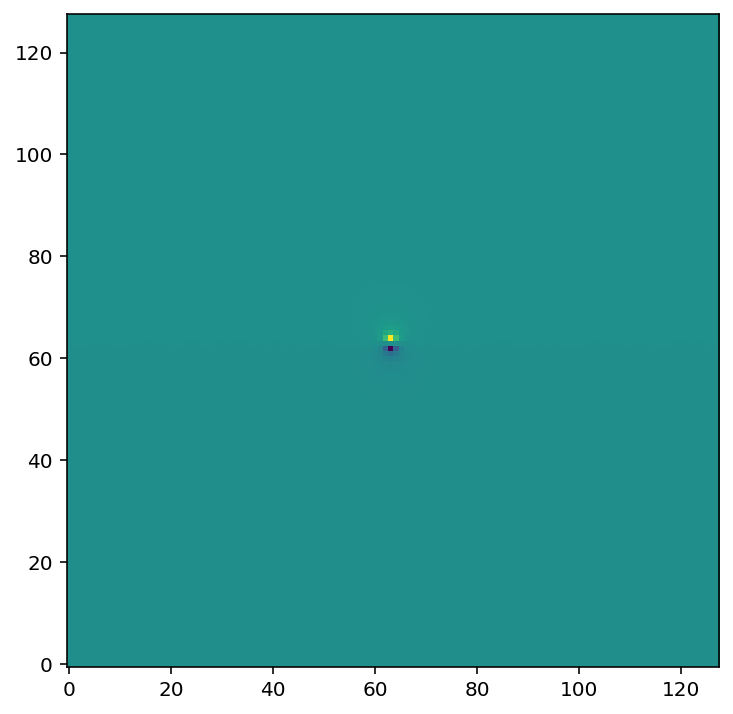

In [15]:
plt.imshow(Gx[:,ix_center[1],:], origin='lower')

<ipython-input-16-c7466af03d5c>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(Gx[:,ix_center[1],:])), origin='lower')


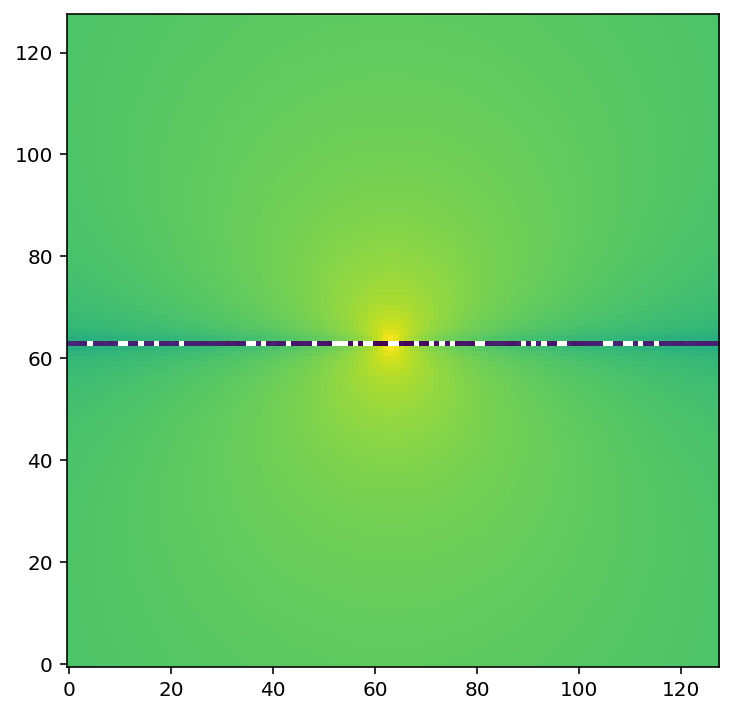

In [16]:
# Use log to show more
plt.imshow(np.log(np.abs(Gx[:,ix_center[1],:])), origin='lower')

# Convolution

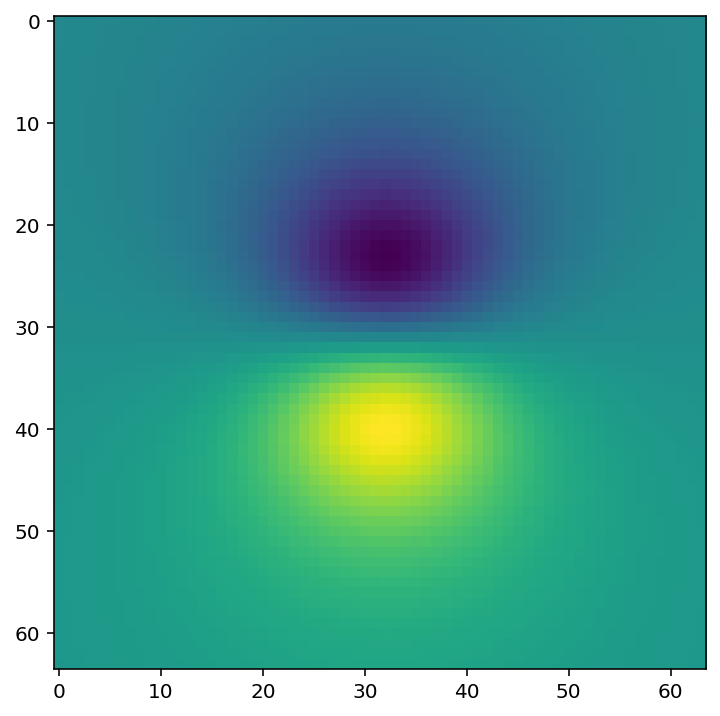

In [17]:
field1=fftconvolve(rho_mesh, Gx, mode='same')

plt.imshow(field1[:,32,:])

In [18]:
# Alternatively, the FFT convolution can be done explicitly. 

# Create an array of the same size as the Green function, 
# and place the rho mesh in the first octant
R2 = np.zeros(Gx.shape)
R2[:BINS[0],:BINS[1],:BINS[2]] = rho_mesh

# The result will be found with this offset
offset = BINS[0]-1 ,BINS[1]-1, BINS[2]-1

field2 = np.real(
    sp_fft.ifftn(sp_fft.fftn(R2)*sp_fft.fftn(Gx))[offset[0]:offset[0]+BINS[0],
                                                     offset[1]:offset[1]+BINS[1],
                                                     offset[2]:offset[2]+BINS[2]]
)
BINS, R2.shape, Gx.shape, field2.shape

((64, 64, 64), (128, 128, 128), (128, 128, 128), (64, 64, 64))

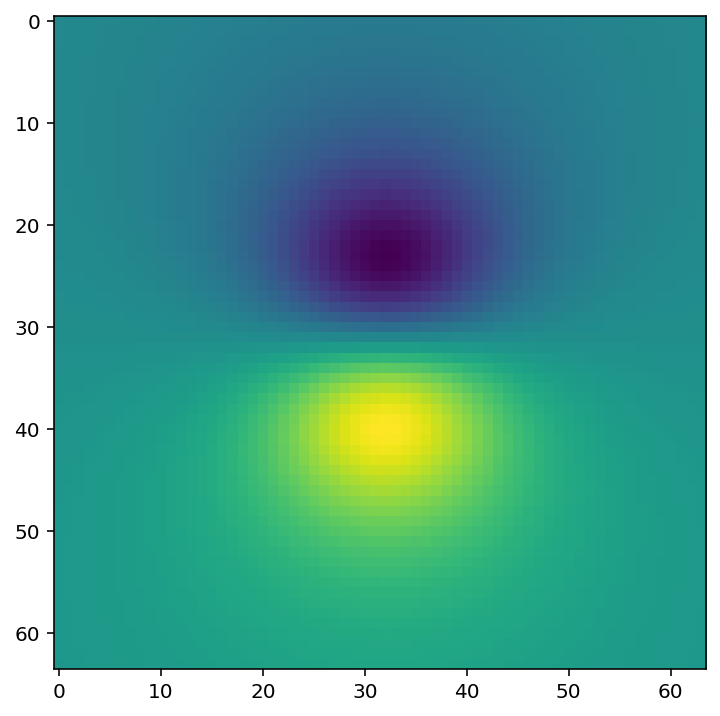

In [19]:
plt.imshow(field2[:,32,:])

In [20]:
# The results are the same
np.abs(field2-field1).max()

1.8973538018496328e-19

# Space Charge mesh

In [21]:
%%time
Ex_mesh = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='x')

CPU times: user 526 ms, sys: 182 ms, total: 708 ms
Wall time: 711 ms


In [22]:
%%time
Ey_mesh = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='y')

CPU times: user 493 ms, sys: 58.1 ms, total: 551 ms
Wall time: 552 ms


In [23]:
%%time
Ez_mesh = spacecharge_mesh(rho_mesh, deltas, gamma=1, component='z')

CPU times: user 491 ms, sys: 55.5 ms, total: 547 ms
Wall time: 547 ms


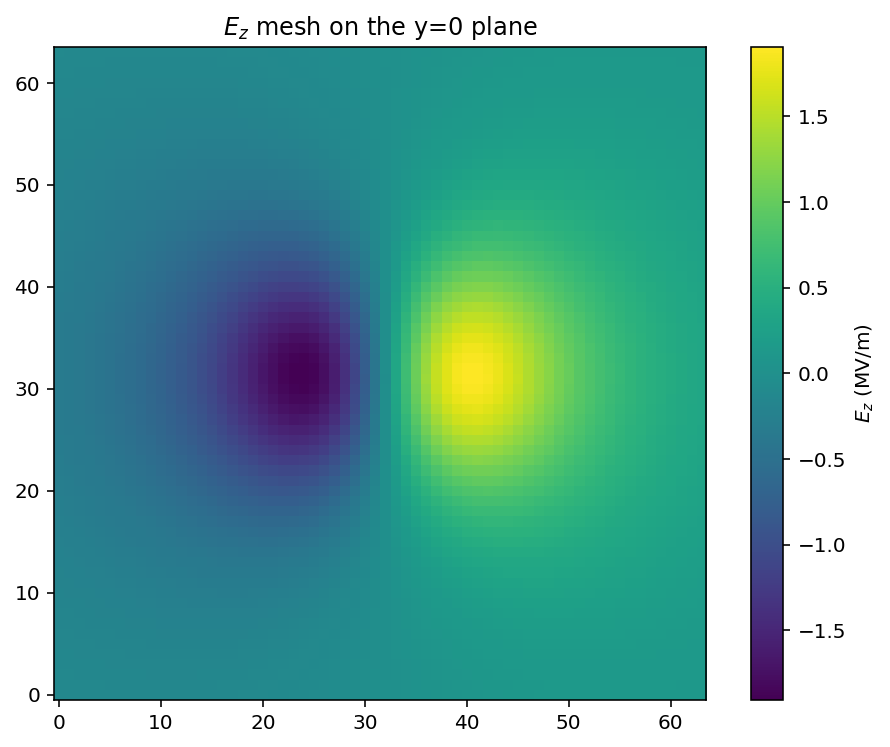

In [24]:
plt.imshow(Ez_mesh[:,BINS[1]//2,:]/1e6, origin='lower')
plt.title(r'$E_z$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$E_z$'+' (MV/m)')

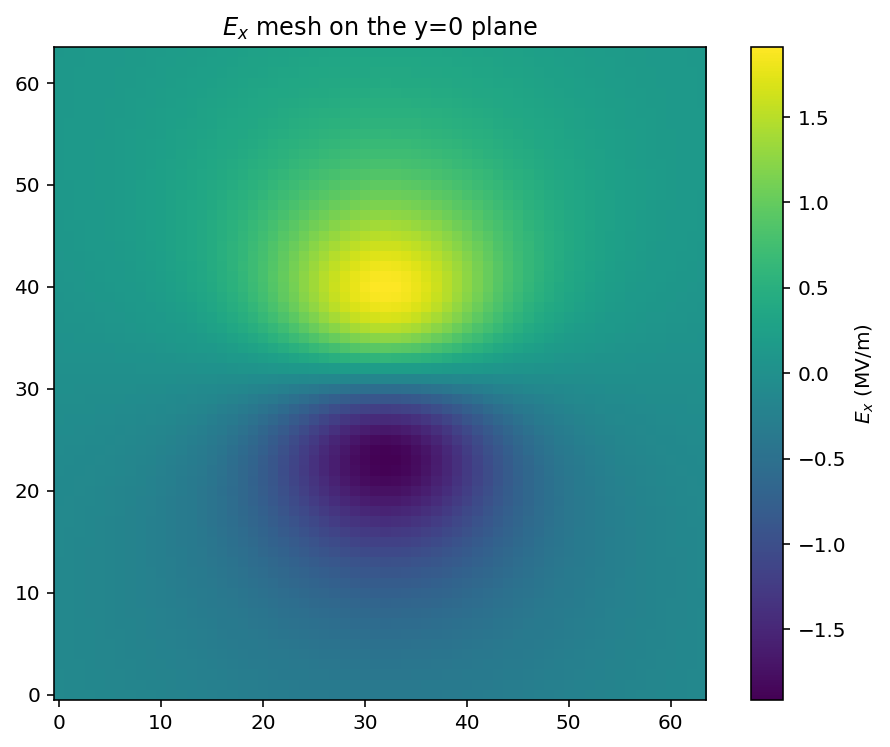

In [25]:
plt.imshow(Ex_mesh[:,BINS[1]//2,:]/1e6, origin='lower')
plt.title(r'$E_x$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$E_x$'+' (MV/m)')

32


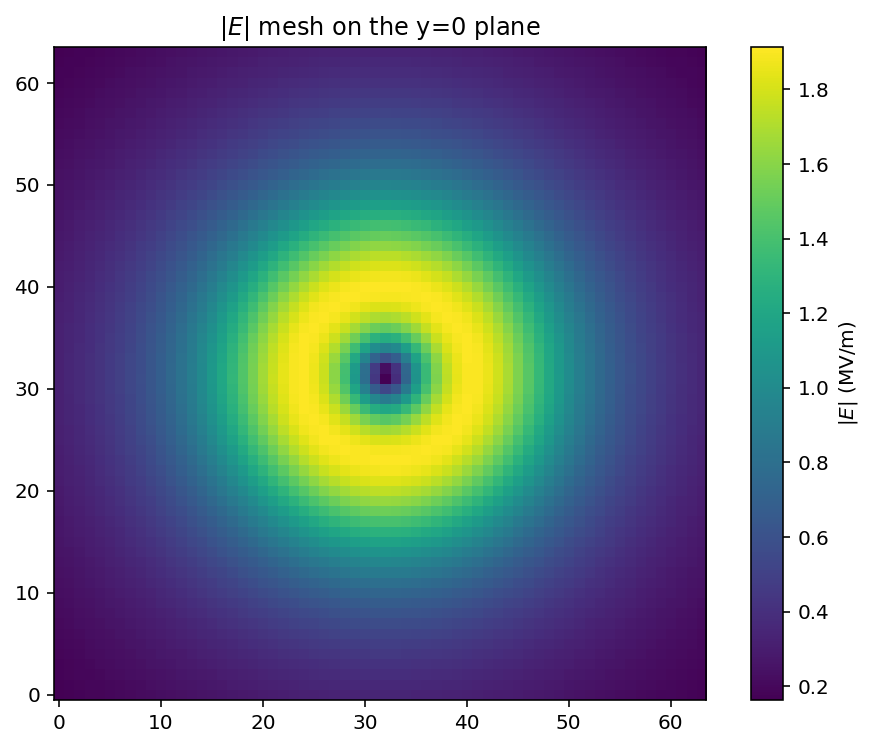

In [26]:
iy =  BINS[1]//2 
print(iy)

Emag = np.sqrt((Ex_mesh[:,iy,:]**2 + Ey_mesh[:,iy,:]**2 + Ez_mesh[:,iy,:]**2))

plt.imshow(Emag/1e6, origin='lower')
plt.title(r'$|E|$' +' mesh on the y=0 plane')
plt.colorbar(label=r'$|E|$'+' (MV/m)')

Text(0, 0.5, '$E_x~(MV/m)$')

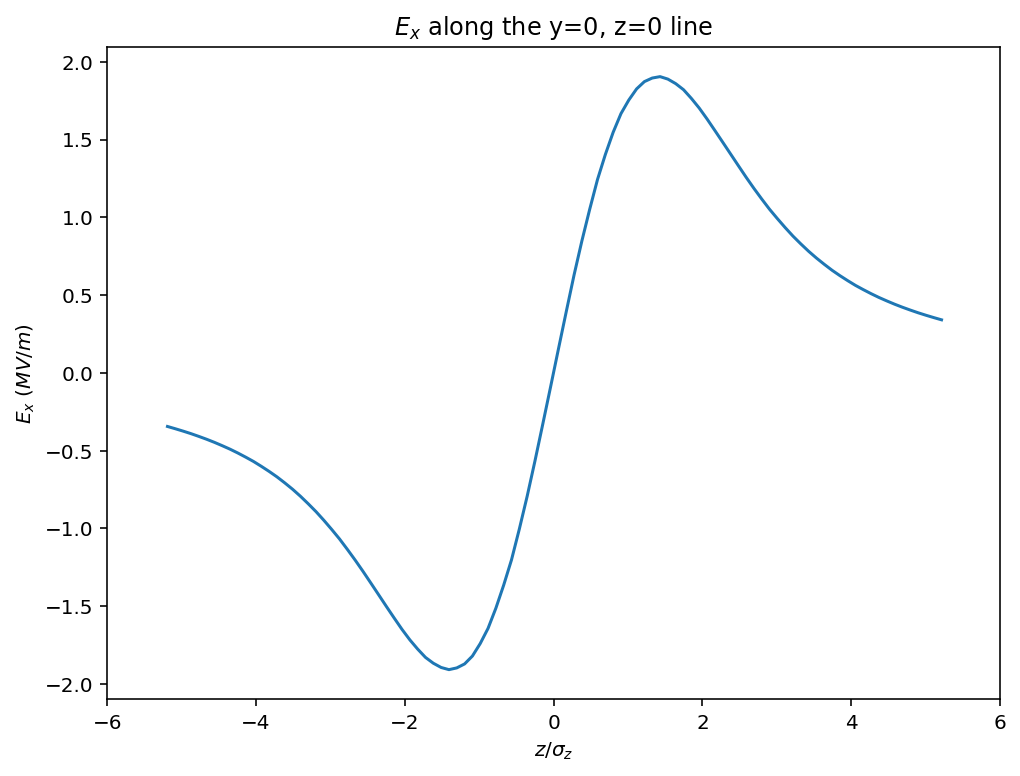

In [27]:
x0 = np.linspace(coord_vecs[0].min(), coord_vecs[0].max() , 100)
xpts = np.array([[x, 0,0] for x in x0])

# Plot on x=0, y=0 line
Ex0 = interpn(coord_vecs, Ex_mesh, xpts)

fig, ax = plt.subplots()
ax.plot(x0/SIGX, Ex0/1e6)

ax.set_title(r'$E_x$'+' along the y=0, z=0 line')
ax.set_xlim(-6, 6)
#ax.set_ylim(-10,10)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_x~(MV/m)$')



Text(0, 0.5, '$E_z~(MV/m)$')

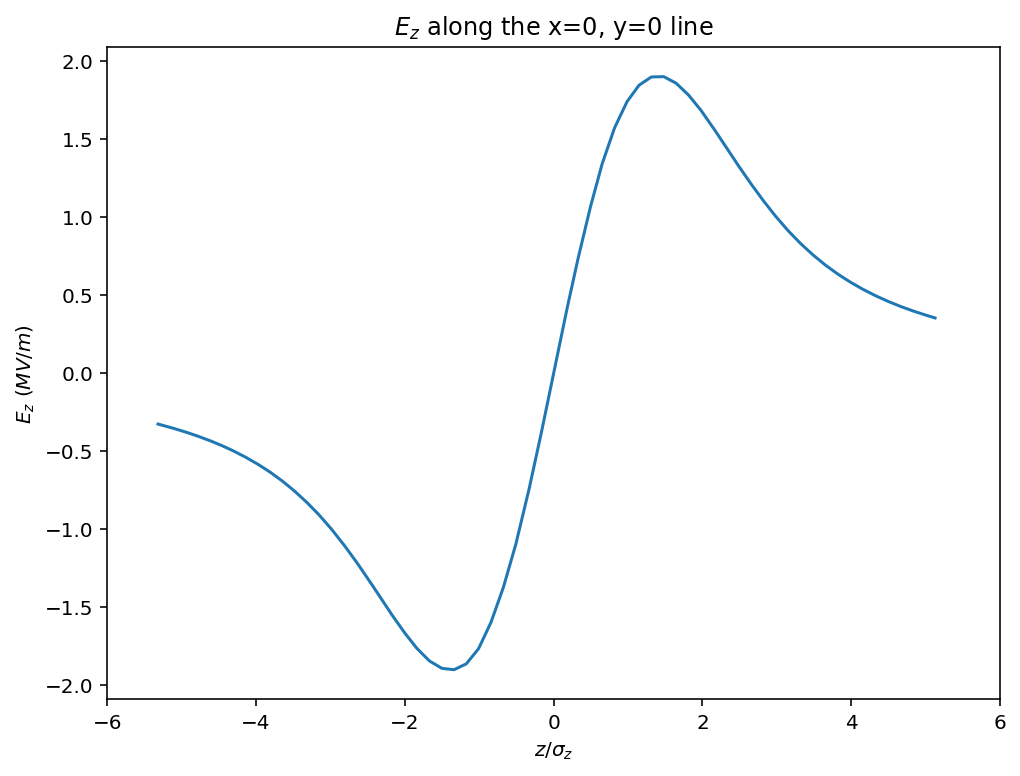

In [28]:
z0 = np.linspace(coord_vecs[2].min(), coord_vecs[2].max() , 1000)
zpts = np.array([[0,0,z] for z in z0])

# Plot on x=0, y=0 line
Ez0 = interpn(coord_vecs, Ez_mesh, zpts)

fig, ax = plt.subplots()
ax.plot(z0/SIGZ, Ez0/1e6)

ax.set_title(r'$E_z$'+' along the x=0, y=0 line')
ax.set_xlim(-6, 6)
#ax.set_ylim(-10,10)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_z~(MV/m)$')

# Summary plots

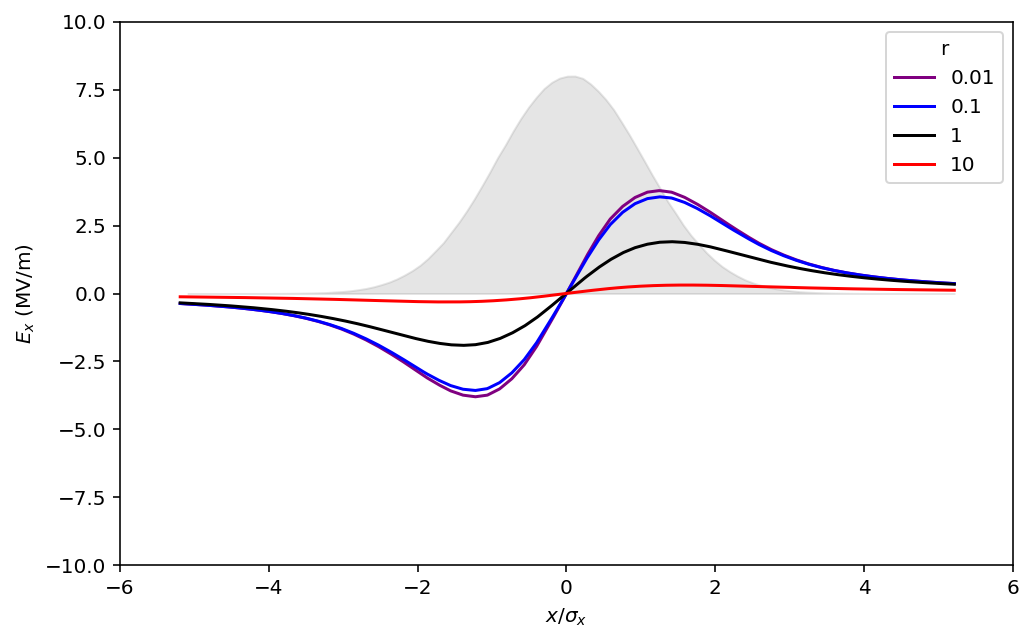

In [29]:
# Ex 
x0 = np.linspace(coord_vecs[0].min(), coord_vecs[0].max() , 1000)
xpts = np.array([[x,0,0] for x in x0])

fig, ax = plt.subplots(figsize=(8,5))

COLOR = {1:'black', 0.1:'blue', 0.01: 'purple', 10:'red'}

for ratio in [.01, .1, 1, 10]:
    deltas0 = deltas.copy()
    deltas0[2] *= ratio
    Ex_mesh = spacecharge_mesh(rho_mesh, deltas0, gamma=1, component='x')

    Ex0 = interpn(coord_vecs, Ex_mesh, xpts)
    
    ax.plot(x0/SIGX, Ex0/1e6, color=COLOR[ratio], label=f'{ratio}')
    
    
# Charge density    
#ax2 = ax.twinx()      
H, edges = np.histogram(particles[:, 0], bins=100)
ax.fill_between(edges[1:]/SIGX, 0, H/H.max()*8, color='gray', alpha=0.2)    

ax.set_xlim(-6, 6)
ax.set_ylim(-10,10)    
ax.set_xlabel(r'$x/\sigma_x$')
ax.set_ylabel(r'$E_x$'+' (MV/m)')    
ax.legend(title='r')

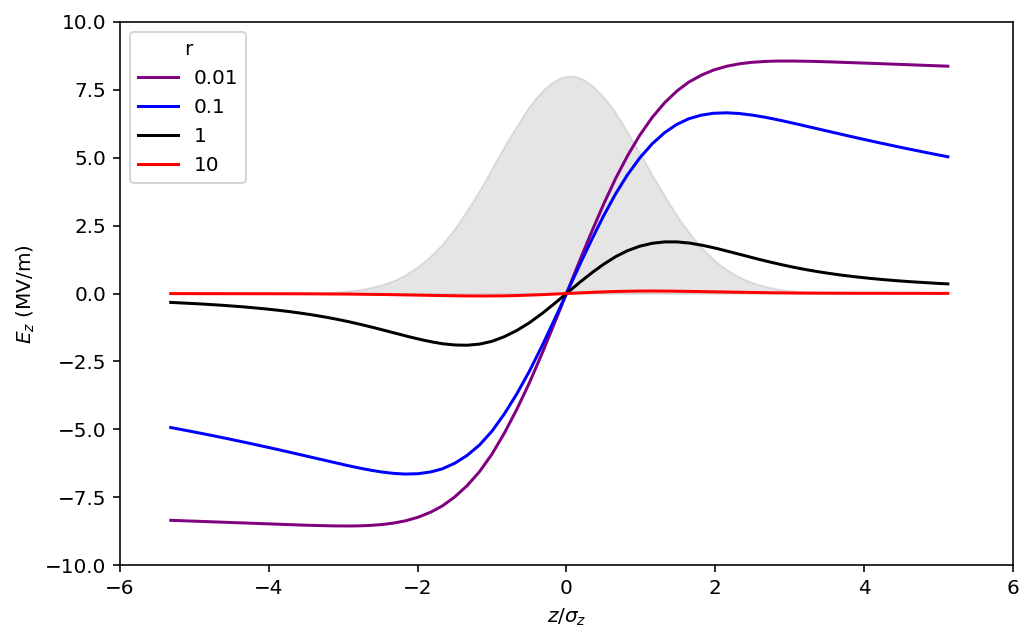

In [30]:
# Ez 
z0 = np.linspace(coord_vecs[2].min(), coord_vecs[2].max() , 1000)
zpts = np.array([[0,0,z] for z in z0])

fig, ax = plt.subplots(figsize=(8,5))

COLOR = {1:'black', 0.1:'blue', 0.01: 'purple', 10:'red'}

for ratio in [.01, .1, 1, 10]:
    deltas0 = deltas.copy()
    deltas0[2] *= ratio
    Ez_mesh = spacecharge_mesh(rho_mesh, deltas0, gamma=1, component='z')

    Ez0 = interpn(coord_vecs, Ez_mesh, zpts)
    
    ax.plot(z0/SIGZ, Ez0/1e6, color=COLOR[ratio], label=f'{ratio}')
    
    
# Charge density    
#ax2 = ax.twinx()      
H, edges = np.histogram(particles[:, 2], bins=100)
ax.fill_between(edges[1:]/SIGZ, 0, H/H.max()*8, color='gray', alpha=0.2)    

ax.set_xlim(-6, 6)
ax.set_ylim(-10,10)    
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_z$'+' (MV/m)')     
ax.legend(title='r')